# Image Stitching

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

figsize=(10, 8)

** Read Image **

In [2]:
bgr1 = cv2.imread('data/mountain1.png')
rgb1 = cv2.cvtColor(bgr1, cv2.COLOR_BGR2RGB)

bgr2 = cv2.imread('data/mountain2.png')
rgb2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)

## Cylinder Warping

In [3]:
def cylinder_warping(images, focal=1000):
    n, h, w = images.shape[:3]
    res = np.zeros([n, h, w, 3])

    s = focal

    # Use inverse warping interpolation
    x_origin = np.floor(w / 2)
    y_origin = np.floor(h / 2)
    x_arange = np.arange(w)
    y_arange = np.arange(h)
    x_prime, y_prime = np.meshgrid(x_arange, y_arange)
    x_prime = x_prime - x_origin
    y_prime = y_prime - y_origin

    for i in range(n):
        img = images[i].flatten()

        x = focal * np.tan(x_prime / s)
        y = np.sqrt(x*x + focal*focal) / s * y_prime
        x += x_origin
        y += y_origin

        idx = np.ones([h, w])
        floor_x = np.floor(x).astype('int32')
        idx[floor_x < 0] = 0; idx[floor_x > w-1] = 0
        floor_x[floor_x < 0] = 0; floor_x[floor_x > w-1] = w-1;

        ceil_x = np.ceil(x).astype('int32')
        idx[ceil_x < 0] = 0; idx[ceil_x > w-1] = 0
        ceil_x[ceil_x < 0] = 0; ceil_x[ceil_x > w-1] = w-1;

        floor_y = np.floor(y).astype('int32')
        idx[floor_y < 0] = 0; idx[floor_y > h-1] = 0
        floor_y[floor_y < 0] = 0; floor_y[floor_y > h-1] = h-1;

        ceil_y = np.ceil(y).astype('int32')
        idx[ceil_y < 0] = 0; idx[ceil_y > h-1] = 0
        ceil_y[ceil_y < 0] = 0; ceil_y[ceil_y > h-1] = h-1;

        xt = ceil_x - x
        yt = ceil_y - y
        for c in range(3):
            left_up = img[c :: 3][floor_y*w + floor_x]
            right_up = img[c :: 3][floor_y*w + ceil_x]
            left_down = img[c :: 3][ceil_y*w + floor_x]
            right_down = img[c :: 3][ceil_y*w + ceil_x]
            t1 = left_up*xt + right_up*(1-xt)
            t2 = left_down*xt + right_down*(1-xt)

            res[i][:,:,c] = t1*yt + t2*(1-yt)

        res[i][idx == 0] = [0, 0, 0]
        
        cv2.imwrite('warp{}.png'.format(i), res[i])
        print('Cylinder Warping for image{}'.format(i))
        
    return res.astype(np.uint8)

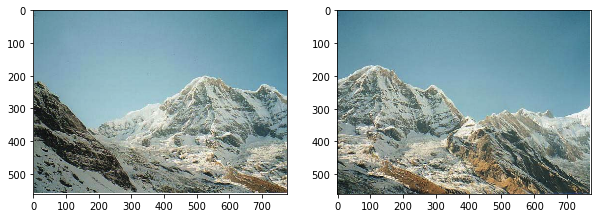

In [4]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
ax[0].imshow(rgb1)
ax[1].imshow(rgb2)
plt.show()

In [5]:
gray1 = cv2.cvtColor(bgr1, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray2 = cv2.cvtColor(bgr2, cv2.COLOR_RGB2GRAY).astype(np.float32)
h1, w1 = gray1.shape
h2, w2 = gray2.shape

** Calculate R **

In [6]:
def calculate_R(gray, ksize=9, S=3, k=0.04):
    K = (ksize, ksize)

    gray_blur = cv2.GaussianBlur(gray, K, S)
    Iy, Ix = np.gradient(gray_blur)

    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    Sx2 = cv2.GaussianBlur(Ix2, K, S)
    Sy2 = cv2.GaussianBlur(Iy2, K, S)
    Sxy = cv2.GaussianBlur(Ixy, K, S)

    detM = (Sx2 * Sy2) - (Sxy ** 2)
    traceM = Sx2 + Sy2

    R = detM - k * (traceM ** 2)
    print(np.min(R), np.max(R))
    
    return R, Ix, Iy, Ix2, Iy2

In [7]:
R1, Ix1, Iy1, Ix21, Iy21 = calculate_R(gray1)
R2, Ix2, Iy2, Ix22, Iy22 = calculate_R(gray2)

-3654.06 6248.17
-4883.72 4392.55


** Find Local Max of R **

In [8]:
def local_max_R(R, thres=0.01):
    kernels = []
    for y in range(3):
        for x in range(3):
            if x == 1 and y == 1: continue
            k = np.zeros((3, 3), dtype=np.float32)
            k[1, 1] = 1
            k[y, x] = -1
            kernels.append(k)

    localMax = np.ones(R.shape, dtype=np.uint8)
    localMax[R <= np.max(R) * thres] = 0

    for k in kernels:
        d = np.sign(cv2.filter2D(R, -1, k))
        d[d < 0] = 0
        localMax &= np.uint8(d)

    print('founded corners:', np.sum(localMax))
    feature_points = np.where(localMax > 0)
    
    return feature_points[1], feature_points[0]

In [9]:
fpx1, fpy1 = local_max_R(R1)
fpx2, fpy2 = local_max_R(R2)

founded corners: 992
founded corners: 1151


** Plot Feature Points **

In [10]:
rgb_fps = np.copy(rgb1)
for y, x in zip(fpy1, fpx1):
    cv2.circle(rgb_fps, (x, y), radius=1, color=[255, 0, 0], thickness=1, lineType=1) 

** Plot Arrows **

In [11]:
rgb_arrows = np.copy(rgb1)
for y, x in zip(fpy1, fpx1):
    ex, ey = int(x + Ix1[y, x] * 3), int(y + Iy1[y, x] * 3)
    ex, ey = np.clip(ex, 0, w1), np.clip(ey, 0, h1)
    cv2.arrowedLine(rgb_arrows, (x, y), (ex, ey), (255, 255, 0), 1)

** Plot Result **

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


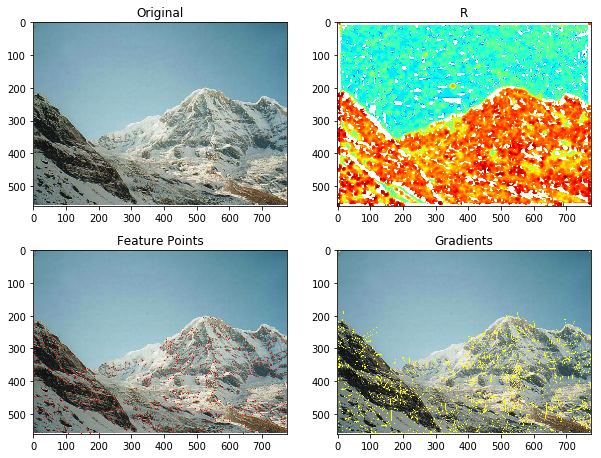

In [12]:
fig, ax = plt.subplots(2, 2, figsize=figsize)
fig.subplots_adjust(wspace=0.2, hspace=0.1)
ax[0, 0].imshow(rgb1); ax[0, 0].set_title('Original')
ax[0, 1].imshow(np.log(R1 + 1e-4), cmap='jet'); ax[0, 1].set_title('R')
ax[1, 0].imshow(rgb_fps); ax[1, 0].set_title('Feature Points')
ax[1, 1].imshow(rgb_arrows); ax[1, 1].set_title('Gradients')
plt.savefig('feature.png'); plt.show()

# Descriptor

## Orientation Assignment

In [13]:
bins = 8

In [14]:
def get_orientations(Ix, Iy, Ix2, Iy2, bins=8):
    M = (Ix2 + Iy2) ** (1/2)

    theta = np.arctan(Iy / (Ix + 1e-8)) * (180 / np.pi)
    theta[Ix < 0] += 180
    theta = (theta + 360) % 360

    bin_size = 360. / bins
    theta_bins = (theta + (bin_size / 2)) // int(bin_size) % 8 # divide to 8 bins

    theta_one_hot = np.zeros((bins,) + Ix.shape)
    for b in range(bins):
        theta_one_hot[b][theta_bins == b] = 1
        theta_one_hot[b] *= M
        theta_one_hot[b] = cv2.GaussianBlur(theta_one_hot[b], (9, 9), 0)

    orientations = np.argmax(theta_one_hot, axis=0)
    
    return orientations, M, theta, theta_bins, theta_one_hot

In [15]:
ori1, M1, t1, tb1, toh1 = get_orientations(Ix1, Iy1, Ix21, Iy21, bins)
ori2, M2, t2, tb2, toh2 = get_orientations(Ix2, Iy2, Ix22, Iy22, bins)

** Plot Orientations **

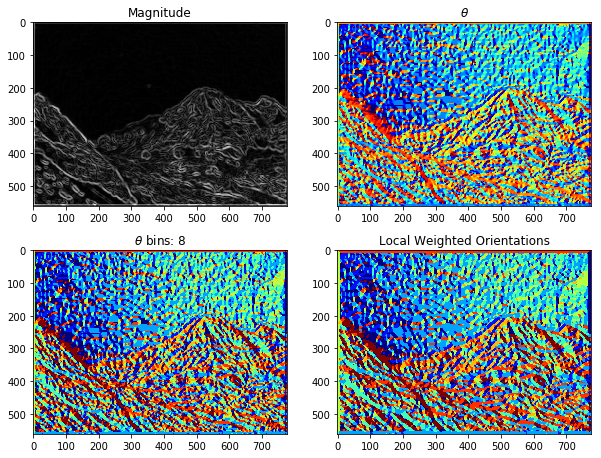

In [16]:
fig, ax = plt.subplots(2, 2, figsize=figsize)
fig.subplots_adjust(wspace=0.2, hspace=0.1)
ax[0, 0].imshow(M1, cmap='gray'); ax[0, 0].set_title('Magnitude')
ax[0, 1].imshow(t1, cmap='jet'); ax[0, 1].set_title(r'$\theta$')
ax[1, 0].imshow(tb1, cmap='jet'); ax[1, 0].set_title(r'$\theta$ bins: ' + str(bins))
ax[1, 1].imshow(ori1, cmap='jet'); ax[1, 1].set_title('Local Weighted Orientations')
plt.savefig('orientations.png'); plt.show()

## Local Image Descriptor

In [17]:
def get_descriptors(fpx, fpy, toh, theta):
    
    bins, h, w = toh.shape

    def get_sub_vector(fy, fx, oy, ox, tr):
        sv = []
        for b in range(bins):
            sv.append(np.sum(tr[b][fy:fy+oy, fx:fx+ox]))
        sv_n1 = [x / (np.sum(sv) + 1e-8) for x in sv]
        sv_clip = [x if x < 0.2 else 0.2 for x in sv_n1]
        sv_n2 = [x / (np.sum(sv_clip) + 1e-8) for x in sv_clip]
        return sv_n2
    
    def get_vector(y, x):
        # +angle in cv2 is counter-clockwise.
        # +y is down in image coordinates.
        M = cv2.getRotationMatrix2D((12, 12), theta[y, x], 1)
        if y-12 < 0 or x-12 < 0: return 0
        toh_rotated = [cv2.warpAffine(t[y-12:y+12, x-12:x+12], M, (24, 24)) for t in toh]
        
        vector = []
        subpatch_offsets = [4, 8, 12, 16]
        for fy in subpatch_offsets:
            for fx in subpatch_offsets:
                vector += get_sub_vector(fy, fx, 4, 4, toh_rotated)
        return vector

    descriptors = []
    for y, x in zip(fpy, fpx):
        vector = get_vector(y, x)
        if np.sum(vector) > 0:
            descriptors.append({'y': y, 'x': x, 'vector': vector})
        
    return descriptors

In [18]:
des1 = get_descriptors(fpx1, fpy1, toh1, t1)
des2 = get_descriptors(fpx2, fpy2, toh2, t2)

# Matching

## Exhaustive Distance Method

In [19]:
def find_matches(des1, des2, thres=0.8):
    df1 = pd.DataFrame(des1)
    df2 = pd.DataFrame(des2)
    v1 = df1.loc[:]['vector'].tolist()
    v2 = df2.loc[:]['vector'].tolist()

    distances = cdist(v1, v2)
    sorted_index = np.argsort(distances, axis=1)
    
    matches = []
    for i, si in enumerate(sorted_index):
        first = distances[i, si[0]]
        second = distances[i, si[1]]
        if first / second < thres:
            matches.append([i, si[0]])
    
    return matches

In [20]:
matches = find_matches(des1, des2, 0.7)
print(len(matches))

190


** Plot Matching **

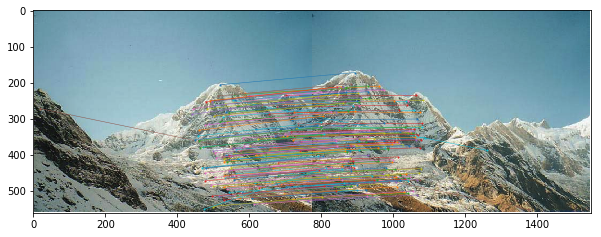

In [21]:
vis = np.zeros([max(h1, h2), w1 + w2, 3], dtype=np.uint8) + 255
vis[:h1, :w1] = rgb1
vis[:h2, w1:] = rgb2

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(vis)

for (m1, m2) in matches:
    x1, y1 = des1[m1]['x'], des1[m1]['y']
    x2, y2 = des2[m2]['x'], des2[m2]['y']
    ax.plot([x1, w1 + x2], [y1, y2], marker='o', linewidth=0.5, markersize=1)

plt.savefig('matches.png'); plt.show()

** Plot feature points **

In [22]:
rgb1_fp = np.copy(rgb1)
rgb2_fp = np.copy(rgb2)
for (m1, m2) in matches:
    x1, y1 = des1[m1]['x'], des1[m1]['y']
    x2, y2 = des2[m2]['x'], des2[m2]['y']
    rgb1_fp[y1-1:y1+2, x1-1:x1+2] = np.array([255, 0, 0])
    rgb2_fp[y2-1:y2+2, x2-1:x2+2] = np.array([0, 0, 255])

## RANSAC Algorithm

In [23]:
def ransac_t(matches, des1, des2, rgb1, rgb2, n=4):
    matches = np.array(matches)
    m1, m2 = matches[:, 0], matches[:, 1]
    
    df1 = pd.DataFrame(des1)
    df2 = pd.DataFrame(des2)
    P1 = np.array(df1.loc[m1][['x', 'y']])
    P2 = np.array(df2.loc[m2][['x', 'y']])

    E, Dxy = [], []
    for k in range(1000):
        samples = np.random.randint(0, len(P1), n)
        dxy = np.mean(P1[samples] - P2[samples], axis=0).astype(np.int)
        diff_xy = np.abs(P1 - (P2 + dxy))
        err = np.sum( np.sign(np.sum(diff_xy, axis=1)) )
        E.append(err); Dxy.append(dxy)

    Ei = np.argsort(E)
    best_dxy = Dxy[Ei[0]]
    
    print('Best dxy: {}, error: {:.4f}'.format(best_dxy, E[Ei[0]]))
    return best_dxy

In [24]:
def get_amap(size1, size2, dxy):
    (h1, w1), (h2, w2), (dx, dy) = size1, size2, dxy
    
    sx = dx if dx > 0 else w2
    sy = dy if dy > 0 else h2
    ex = w1 if dx > 0 else -dx
    ey = h1 if dy > 0 else -dy
    nx, ny = abs(sx - ex), abs(sy - ey)
    
    xlin = np.linspace(1, 0, nx) if dx > 0 else np.linspace(0, 1, nx)
    ylin = np.linspace(1, 0, ny) if dy > 0 else np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(xlin, ylin)
    
    #bw = (xv + yv) / 2
    bw = xv
    bw = np.stack([bw, bw, bw], axis=2)
    
    if sx > ex: sx, ex = ex, sx
    if sy > ey: sy, ey = ey, sy
    
    return (bw, 1 - bw), (sx, sy), (ex, ey)

def merge_t(im1, im2, dxy):
    h1, w1, c = im1.shape
    h2, w2, c = im2.shape
    (bw1, bw2), (sx, sy), (ex, ey) = get_amap((h1, w1), (h2, w2), dxy)
    (dx, dy) = dxy
    
    h, w = max(h1, h2 + abs(dy)), max(w1, w2 + abs(dx))
    m1 = np.zeros((h, w, c), dtype=np.float32)
    m2 = np.zeros((h, w, c), dtype=np.float32)
    mw1 = np.ones((h, w, c), dtype=np.float32)
    mw2 = np.ones((h, w, c), dtype=np.float32)
    
    x1, y1 = -min(0, dx), -min(0, dy)
    x2, y2 = max(0, dx), max(0, dy)
    
    m1[y1:y1+h1, x1:x1+w1] += im1
    m2[y2:y2+h2, x2:x2+w2] += im2

    mw1[sy:ey, sx:ex] *= bw1
    mw1[m2 == 0] = 1
    mw1[m1 == 0] = 0
    
    mw2[sy:ey, sx:ex] *= bw2
    mw2[m1 == 0] = 1
    mw2[m2 == 0] = 0    
    
    merged = mw1 * m1 + mw2 * m2
    
    return merged.astype(np.uint8)

Best dxy: [445  17], error: 188.0000


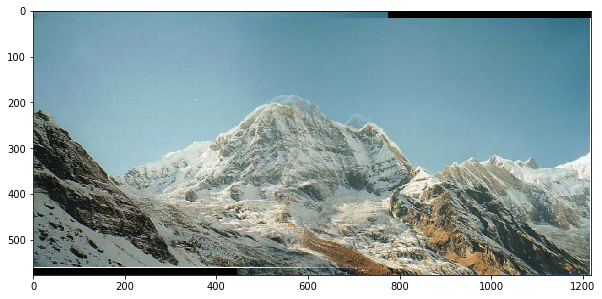

In [25]:
dxy = ransac_t(matches, des1, des2, rgb1, rgb2, n=4)
plt.figure(figsize=figsize)
plt.imshow(merge_t(rgb1, rgb2, dxy))
plt.savefig('ransac_t.png'); plt.show()

## RANSAC with Angles

In [26]:
def get_angle(dx, dy):
    angle = np.arctan(dy / (dx + 1e-8)) * (180 / np.pi)
    if dx < 0: angle += 180
    angle = (angle + 360) % 360
    return angle

def ransac_rt(matches, des1, des2, rgb1, rgb2):
    matches = np.array(matches)
    m1, m2 = matches[:, 0], matches[:, 1]
    
    df1, df2 = pd.DataFrame(des1), pd.DataFrame(des2)
    X1, Y1 = np.array(df1.loc[m1]['x']), np.array(df1.loc[m1]['y'])
    X2, Y2 = np.array(df2.loc[m2]['x']), np.array(df2.loc[m2]['y'])
    
    P1 = np.array([X1, Y1]).T.reshape(1, -1, 2)
    P2 = np.array([X2, Y2]).T.reshape(1, -1, 2)
    
    E, content = [], []

    for i in range(1000):
        sampled_matches = np.random.randint(0, len(matches), 2)

        m1, m2 = sampled_matches
        
        m1_x1, m1_y1, m1_x2, m1_y2 = X1[m1], Y1[m1], X2[m1], Y2[m1]
        m2_x1, m2_y1, m2_x2, m2_y2 = X1[m2], Y1[m2], X2[m2], Y2[m2]
        
        dx1, dy1 = m2_x1 - m1_x1, m2_y1 - m1_y1
        dx2, dy2 = m2_x2 - m1_x2, m2_y2 - m1_y2
        
        a1 = get_angle(dx1, dy1)
        a2 = get_angle(dx2, dy2)
        
        da = a1 - a2 # im2 rotate to im1
        R = cv2.getRotationMatrix2D((m1_x2, m1_y2), -da, 1) # cv2 rotate is counter-clockwise, y down +
        
        P2_r = cv2.transform(P2, R)
        
        dx, dy = m1_x1 - m1_x2, m1_y1 - m1_y2
        P2_r[:, :, 0] += dx
        P2_r[:, :, 1] += dy
        
        e = np.abs(P2_r - P1)
        e = np.sum(np.sign(e[e > 1]))
        E.append(e)
        content.append([dx, dy, -da, m1_x2, m1_y2])
        
    E = np.array(E)
    Ei = np.argsort(E)
    
    bm = Ei[:10]
    
    print('Best matches:', bm)
    print('Error:', E[bm])
    
    return np.mean(np.array(content)[bm], axis=0)

In [27]:
def merge_rt(im1, im2, dx, dy, da, x2, y2): 
    dx, dy, x2, y2 = int(dx), int(dy), int(x2), int(y2)
    
    h1, w1, c = im1.shape
    h2, w2, c = im2.shape    
    (bw1, bw2), (sx, sy), (ex, ey) = get_amap((h1, w1), (h2, w2), (dx, dy))
    
    h, w = max(h1, h2 + abs(dy)), max(w1, w2 + abs(dx))
    m1 = np.zeros((h, w, c), dtype=np.float32)
    m2 = np.zeros((h, w, c), dtype=np.float32)
    mw1 = np.ones((h, w, c), dtype=np.float32)
    mw2 = np.ones((h, w, c), dtype=np.float32)
    
    # rotate im2
    R = cv2.getRotationMatrix2D((x2, y2), da, 1)
    im2 = cv2.warpAffine(im2, R, (w2, h2))
    
    x1, y1 = -min(0, dx), -min(0, dy)
    x2, y2 = max(0, dx), max(0, dy)
    
    m1[y1:y1+h1, x1:x1+w1] += im1
    m2[y2:y2+h2, x2:x2+w2] += im2

    mw1[sy:ey, sx:ex] *= bw1
    mw1[m2 == 0] = 1
    mw1[m1 == 0] = 0
    mw2[sy:ey, sx:ex] *= bw2
    mw2[m1 == 0] = 1
    mw2[m2 == 0] = 0    
    
    merged = mw1 * m1 + mw2 * m2
    
    return merged.astype(np.uint8)

Best matches: [813  22 279 782  99 212 135 469 762 898]
Error: [273 276 279 279 282 282 283 284 284 284]
418.7 24.3 10.9971605303 149.0 282.1


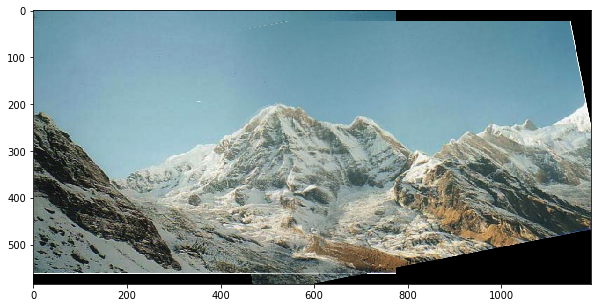

In [28]:
dx, dy, da, x2, y2 = ransac_rt(matches, des1, des2, rgb1, rgb2); print(dx, dy, da, x2, y2)
plt.figure(figsize=figsize)
plt.imshow(merge_rt(rgb1, rgb2, dx, dy, da, x2, y2))
plt.savefig('ransac_rt.png'); plt.show()